In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot
from sklearn.metrics import accuracy_score
import os
import glob
import pathlib
from PIL import Image
import random

In [2]:
path=pathlib.Path(r"C:\Users\Admin\Desktop\Capstone Project\Rice Image Dataset\archive\Rice_Image_Dataset")

In [3]:
class_names = ['Arborio', 'basmati', 'ipsala', 'jasmine', 'karacadag']

In [4]:
for class_name in class_names:
    class_path = path / class_name  # Path to the class folder
    image_files = list(class_path.glob('*.jpg'))  # Assuming images are in JPEG format
    

In [5]:
data_transform=transforms.Compose([
    transforms.RandomAutocontrast(0.2),
    transforms.Resize((250,250)),
    transforms.RandomGrayscale(0.2),
    transforms.RandomAdjustSharpness(0.2),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomInvert(0.2),
    transforms.RandomPerspective(p=0.2),
    transforms.RandomRotation(degrees=(0,360)),
    transforms.RandomEqualize(0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
data=ImageFolder(root=path,transform=data_transform)

In [7]:
data

Dataset ImageFolder
    Number of datapoints: 75000
    Root location: C:\Users\Admin\Desktop\Capstone Project\Rice Image Dataset\archive\Rice_Image_Dataset
    StandardTransform
Transform: Compose(
               RandomAutocontrast(p=0.2)
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
               RandomGrayscale(p=0.2)
               RandomAdjustSharpness(sharpness_factor=0.2,p=0.5)
               RandomHorizontalFlip(p=0.2)
               RandomVerticalFlip(p=0.2)
               RandomInvert(p=0.2)
               RandomPerspective(p=0.2)
               RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
               RandomEqualize(p=0.2)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
len(data)

75000

In [9]:
train,test=torch.utils.data.random_split(data,[0.8,0.2])

In [10]:
len(train),len(test)

(60000, 15000)

In [11]:
train_data=DataLoader(dataset=train,batch_size=50,shuffle=True)
test_data=DataLoader(dataset=test,batch_size=50,shuffle=False)

In [66]:
class model(nn.Module):
    def __init__(self):
        super(model,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=50,kernel_size=3)  
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=3)
        
        self.conv2=nn.Conv2d(in_channels=50,out_channels=100,kernel_size=3)
        self.relu2=nn.ReLU()
        self.pool2=nn.MaxPool2d(kernel_size=3)
        
        self.conv3=nn.Conv2d(in_channels=100,out_channels=150,kernel_size=3)
        self.relu3=nn.ReLU()
        self.pool3=nn.MaxPool2d(kernel_size=3)
        
        
        self.fc1 = nn.Linear(150 * 8 * 8, 500)
        self.dropout1=nn.Dropout(0.5)
        self.fc2=nn.Linear(500,750)
        self.dropout2=nn.Dropout(0.5)
        self.fc3=nn.Linear(750,1000)
        self.dropout3=nn.Dropout(0.5)
        self.fc4=nn.Linear(1000,len(data.classes))
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu1(x)
        x=self.pool1(x)
        
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.pool2(x)
        
        x=self.conv3(x)
        x=self.relu3(x)
        x=self.pool3(x)
        
        x = torch.flatten(x, 1)
        x = nn.ReLU()(self.fc1(x))
        x=self.dropout1(x)
        
        x=nn.ReLU()(self.fc2(x))
        x=self.dropout2(x)
        
        x=nn.ReLU()(self.fc3(x))
        x=self.dropout3(x)
        
        x=self.fc4(x)
        return x 

In [13]:
model=model().cuda()

In [14]:
summary(model,input_size=(3,250,250),batch_size=50)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [50, 50, 248, 248]           1,400
              ReLU-2         [50, 50, 248, 248]               0
         MaxPool2d-3           [50, 50, 82, 82]               0
            Conv2d-4          [50, 100, 80, 80]          45,100
              ReLU-5          [50, 100, 80, 80]               0
         MaxPool2d-6          [50, 100, 26, 26]               0
            Conv2d-7          [50, 150, 24, 24]         135,150
              ReLU-8          [50, 150, 24, 24]               0
         MaxPool2d-9            [50, 150, 8, 8]               0
           Linear-10                  [50, 500]       4,800,500
          Dropout-11                  [50, 500]               0
           Linear-12                  [50, 750]         375,750
          Dropout-13                  [50, 750]               0
           Linear-14                 [5

In [15]:
criteria = nn.CrossEntropyLoss().cuda()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [16]:
patience=3
best_test_loss=float('inf')
early_stop_counter=0

In [17]:
num_epochs = 25  # the number of epochs for training
training_loss=[]
testing_loss=[]
training_accuracy=[]
testing_accuracy=[]
predicted=[]
known=[]
epochss=[]
# Start of training section
for epoch in range(num_epochs):
    model.train()  # Setting the model to training mode
    train_loss = 0
    train_predict = []  # List to store training predictions
    train_labels = []  # List to store training labels

    for i, (inputs, labels) in enumerate(train_data):
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()  # Zeroing the gradients
        outputs = model(inputs)  # Getting the model predictions
        loss = criteria(outputs, labels)  # Calculating the loss using Cross Entropy
        loss.backward()
        optimizer.step()  # Using the Adam Optimizer to optimize the model
        train_loss += loss.item()

        # Store predictions and labels for training accuracy calculation
        train_predict.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Start the Validation section
    model.eval()  # Setting the model to evaluation mode
    test_loss = 0
    test_predict = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in test_data:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)  # Getting the model predictions
            test_loss += criteria(outputs, labels).item()
            test_predict.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_data)
    test_accuracy = accuracy_score(test_labels, test_predict)  # Calculate the test accuracy
    train_accuracy = accuracy_score(train_labels, train_predict)  # Calculate the training accuracy

    print(f'Epoch [{epoch + 1}] Train Loss: {train_loss / len(train_data)} '
          f'Test Loss: {test_loss} '
          f'Train Accuracy: {train_accuracy} '
          f'Test Accuracy: {test_accuracy}')
    training_accuracy.append(train_accuracy)
    testing_accuracy.append(test_accuracy)
    training_loss.append(train_loss / len(train_data))
    testing_loss.append(test_loss)
    epochss.append(epoch + 1)
    
    if epoch==num_epochs:
        predicted.append(test_predict)
        known.append(test_labels)

    # Early stopping section
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            predicted.append(test_predict)
            known.append(test_labels)
            print('Early stopping triggered')
            break

print('Finished Training')

Epoch [1] Train Loss: 0.49427984210352105 Test Loss: 0.24032945107668638 Train Accuracy: 0.8057666666666666 Test Accuracy: 0.9063333333333333
Epoch [2] Train Loss: 0.27601318379243217 Test Loss: 0.1885134212921063 Train Accuracy: 0.8942 Test Accuracy: 0.9304666666666667
Epoch [3] Train Loss: 0.22144921527244152 Test Loss: 0.19473163296778997 Train Accuracy: 0.9175666666666666 Test Accuracy: 0.9284
Epoch [4] Train Loss: 0.1979086550992603 Test Loss: 0.13398988142920037 Train Accuracy: 0.927 Test Accuracy: 0.9504666666666667
Epoch [5] Train Loss: 0.18623141842273375 Test Loss: 0.12923257685576875 Train Accuracy: 0.9328 Test Accuracy: 0.9532
Epoch [6] Train Loss: 0.18198356621743492 Test Loss: 0.14663819584064186 Train Accuracy: 0.9336166666666667 Test Accuracy: 0.9484666666666667
Epoch [7] Train Loss: 0.16896455727828047 Test Loss: 0.11214843940300247 Train Accuracy: 0.9396333333333333 Test Accuracy: 0.9593333333333334
Epoch [8] Train Loss: 0.16684560325772813 Test Loss: 0.13139219993104

In [32]:
df=pd.DataFrame()
df['known']=known
df['predicted']=predicted

In [34]:
df1=df

In [35]:
df1.squeeze()

known        [2, 4, 3, 0, 4, 4, 0, 3, 4, 2, 0, 4, 1, 1, 4, ...
predicted    [2, 4, 3, 0, 4, 4, 0, 3, 4, 2, 0, 4, 1, 1, 4, ...
Name: 0, dtype: object

In [39]:
df1.iloc[:-1]

,known,predicted


In [40]:
known1=known

In [56]:
known1=np.array(known)
predicted1=np.array(predicted)

In [45]:
known1.flatten()
predicted1.flatten()

array([2, 4, 3, ..., 2, 1, 4], dtype=int64)

In [59]:
df1=pd.DataFrame()
df1['known']=known1.flatten()
df1['predicted']=predicted1.flatten()

In [60]:
df1

,known,predicted
0,2,2
1,4,4
2,3,3
3,0,0
4,4,4
...,...,...
14995,4,0
14996,3,3
14997,2,2
14998,1,1


In [61]:
accuracy_score(df1['known'],df1['predicted'])

0.9555333333333333

In [62]:
from sklearn.metrics import classification_report

In [63]:
print(classification_report(df1['known'],df1['predicted']))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3012
           1       0.98      0.96      0.97      2970
           2       1.00      0.96      0.98      3014
           3       0.91      0.97      0.94      3040
           4       0.98      0.93      0.95      2964

    accuracy                           0.96     15000
   macro avg       0.96      0.96      0.96     15000
weighted avg       0.96      0.96      0.96     15000



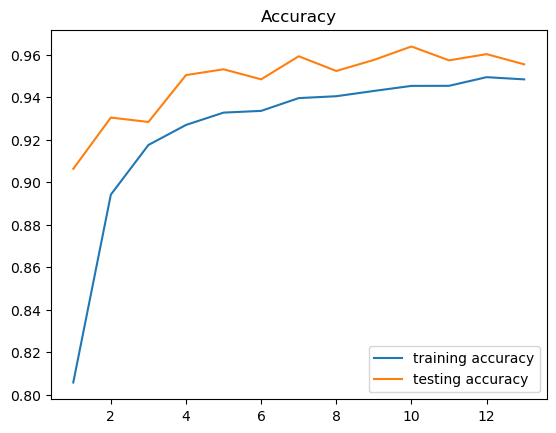

In [88]:
sns.lineplot(x=epochss,y=training_accuracy,label='training accuracy')
sns.lineplot(x=epochss,y=testing_accuracy,label='testing accuracy')
plt.title('Accuracy')
plt.show()

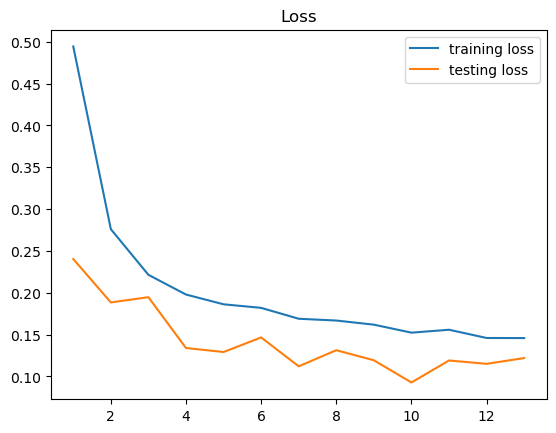

In [89]:
sns.lineplot(x=epochss,y=training_loss,label='training loss')
sns.lineplot(x=epochss,y=testing_loss,label='testing loss')
plt.title('Loss')
plt.show()

In [64]:
torch.save(model.state_dict(), 'first_model_state_dict')

In [67]:
loaded_model = model().cuda()

In [68]:
dict=torch.load('first_model_state_dict')

In [69]:
loaded_model.load_state_dict(dict)

<All keys matched successfully>

In [71]:
image_path = r'C:\Users\Admin\Desktop\Capstone Project\Rice Image Dataset\archive\Rice_Image_Dataset\Jasmine\Jasmine (35).jpg'
image = Image.open(image_path)

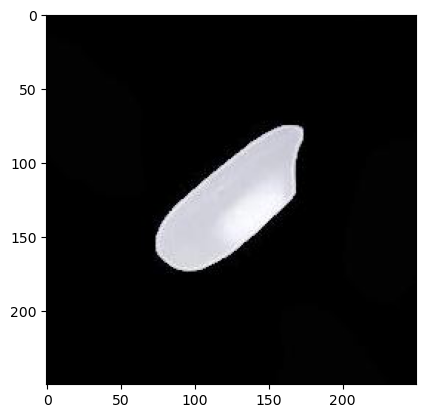

In [72]:
plt.imshow(image)

In [73]:
image=data_transform(image)  
image=image.unsqueeze(0)

In [74]:
loaded_model.eval()

model(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9600, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=750, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=750, out_features=1000, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=1000, out_features=5, bias=True)
)

In [75]:
with torch.no_grad():
    outputs = loaded_model(image.cuda())  # Assuming your model is on the GPU
    _, predicted = torch.max(outputs, 1)

# Define your classes
classes = ['arborio', 'basmati', 'ipsala', 'jasmine', 'karacadag']

# Get the predicted class label
predicted_class = classes[predicted.item()]

# Print the predicted class
print("Predicted class:", predicted_class)

Predicted class: jasmine
